# 목차
1. 분석 방향
2. 데이터 Overview

-------------
# 1. 분석 방향
해당 데이터는 금융 거래에 대한 데이터이다.  
사기 거래에 대한 여부가 나타나 있으며, 이번 분석에서는 이러한 데이터를 바탕으로 발생한 금융 사기에 대한 학습과 모델링을 통하여 범죄가 발생했음을 빠르게 판단할 수 있는 모델을 만들고자 한다.

사기와 관계가 있는 정보들과 그렇지 않은 정보(개인정보 등)을 분류하고, 그렇지 않은 데이터들을 하나의 ID화 하여 동일인물인지 아닌지를 구분하는 용도로 사용한다.

### 접근 방향
+ 사기 거래의 경우 카드 소유자의 거주지(도로명, 도시, 주, 우편번호, 주소명, 좌표)와 거래 위치(상점 이름, 좌표)상당한 거리가 있을 것이다.
+ 단기간에 여러 번 거래가 이루어졌을 경우 사기일 가능성이 크다
+ 일정 금액 이상의 큰 금액의 거래일 경우 사기를 의심해야한다.

--------------
# 2. 데이터 Overview

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import hashlib

def to_id(x):
    return hashlib.sha256(str(x).encode()).hexdigest()

In [25]:
fraud_df = pd.read_csv('fraud.csv')
fraud_df.columns=["거래 발생 시간","카드 번호","가맹점 이름","업종","금액","이름","성","성별","도로명","도시","주","우편번호","위도","경도","인구 수","직업","생년월일","거래 번호","유닉스 시간","거래 위도","거래 경도","사기 여부"]

In [26]:
pd.set_option('display.max_columns',50)
fraud_df.head()
# 카드 번호 길이가 제각각
# 가맹점이랑 거래 위도 경도랑 같은건가?

,거래 발생 시간,카드 번호,가맹점 이름,업종,금액,이름,성,성별,도로명,도시,주,우편번호,위도,경도,인구 수,직업,생년월일,거래 번호,유닉스 시간,거래 위도,거래 경도,사기 여부
0,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
1,2019-01-01 00:12:34,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,NJ,7208,40.6747,-74.2239,124967,Operational researcher,1980-12-21,09eff9c806365e2a6be12c1bbab3d70e,1325376754,40.079588,-74.848087,0
2,2019-01-01 00:17:16,180048185037117,fraud_Kling-Grant,grocery_net,46.28,Mary,Wall,F,2481 Mills Lock,Plainfield,NJ,7060,40.6152,-74.4150,71485,Leisure centre manager,1974-07-19,19e23c6a300c774354417befe4f31f8c,1325377036,40.021888,-74.228188,0
3,2019-01-01 00:20:15,374930071163758,fraud_Deckow-O'Conner,grocery_pos,64.09,Daniel,Escobar,M,61390 Hayes Port,Romulus,MI,48174,42.2203,-83.3583,31515,Police officer,1971-11-05,6f363661ba6b55889e488dd178f2a0af,1325377215,42.360426,-83.552316,0
4,2019-01-01 00:23:41,2712209726293386,fraud_Balistreri-Nader,misc_pos,25.58,Jenna,Brooks,F,50872 Alex Plain Suite 088,Baton Rouge,LA,70808,30.4066,-91.1468,378909,"Designer, furniture",1977-02-22,1654da2abfb9e79a5f99167fc9779558,1325377421,29.737426,-90.853194,0


In [27]:
fraud_df.info()
# Nan으로 처리된 결측치는 없음 -> 다른 값이 있는지는 확인 필요
# object로 된 값들이 너무 많음 데이터 변환 필요

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   거래 발생 시간  491134 non-null  object 
 1   카드 번호     491134 non-null  int64  
 2   가맹점 이름    491134 non-null  object 
 3   업종        491134 non-null  object 
 4   금액        491134 non-null  float64
 5   이름        491134 non-null  object 
 6   성         491134 non-null  object 
 7   성별        491134 non-null  object 
 8   도로명       491134 non-null  object 
 9   도시        491134 non-null  object 
 10  주         491134 non-null  object 
 11  우편번호      491134 non-null  int64  
 12  위도        491134 non-null  float64
 13  경도        491134 non-null  float64
 14  인구 수      491134 non-null  int64  
 15  직업        491134 non-null  object 
 16  생년월일      491134 non-null  object 
 17  거래 번호     491134 non-null  object 
 18  유닉스 시간    491134 non-null  int64  
 19  거래 위도     491134 non-null  float64
 20  거래 경

In [28]:
fraud_df.describe()

,카드 번호,금액,우편번호,위도,경도,인구 수,유닉스 시간,거래 위도,거래 경도,사기 여부
count,4.911340e+05,491134.000000,491134.000000,491134.000000,491134.000000,4.911340e+05,4.911340e+05,491134.000000,491134.000000,491134.000000
mean,3.706013e+17,69.050120,50770.532384,37.931230,-90.495619,1.213922e+05,1.358730e+09,37.930272,-90.495411,0.002533
std,1.260229e+18,160.322867,26854.947965,5.341193,12.990732,3.725751e+05,1.819402e+07,5.372986,13.004100,0.050264
min,5.038744e+11,1.000000,1843.000000,24.655700,-122.345600,4.600000e+01,1.325376e+09,23.655789,-123.345106,0.000000
25%,2.131124e+14,8.960000,28405.000000,33.746700,-97.235100,1.228000e+03,1.343087e+09,33.781388,-96.984814,0.000000
50%,3.531130e+15,42.170000,49628.000000,38.507200,-87.591700,5.760000e+03,1.357257e+09,38.545124,-87.573441,0.000000
75%,4.653879e+15,80.330000,75048.000000,41.520500,-80.731000,5.083500e+04,1.374626e+09,41.624294,-80.685567,0.000000
max,4.956829e+18,25086.940000,99323.000000,48.887800,-69.965600,2.906700e+06,1.388534e+09,49.887523,-68.965624,1.000000


### 요약

#### 스키마 분석

|변수|정의|설명|타입|
|-----|---|---|---|
|trans_date_trans_time|거래 발생 시간|datetime|object|
|cc_num|카드 번호|12\~19자리의 integer|int|
|merchant|가맹점 이름|'fraud_'+alphabet|object|
|category|업종|alphabet+'_'+alphabet|object|
|amt|금액|continuous|float|
|first|이름|alphabet|object|
|last|성|alphabet|object|
|gender|성별|F,M으로 구분되며 binary|object|
|street|도로명|integer + alphabet|object|
|city|도시|alphabet|object|
|state|주|2글자의 upper alphabet|object|
|zip|우편번호|4~5자의 integer|int|
|lat|위도|continuous|float|
|long|경도|continuous|float|
|city_pop|인구 수|quantitative|int|
|job|직업|alphabet|object|
|dob|생년월일|datetime|object|
|trans_num|거래 번호|alphabet + integer|object|
|unix_time|유닉스 시간|10자리 integer|int|
|merch_lat|거래 경도|continuous|float|
|merch_long|거래 위도|continuous|float|
|is_fraud|사기 여부|0,1으로 구분되며 binary|int|

+ 데이터 변환
    + 거래 발생 시간 : datetime
    + 카드 번호 : string
    + 가맹점 이름 : string
        + 이름 앞에 적혀진 fraud 제거 
    + 업종 : string
    + 이름 : string
    + 성 : string
    + 성별 : int(0,1)
    + 도로명 : string
    + 도시 : string
    + 주 : stirng
    + 우편번호 : string
        + 미국의 ZIP 코드는 5자리. 4자리인 경우는 앞에 0을 포함
    + 직업 : string
    + 생년월일 : datetime
    + 거래 번호 :string
    + 유닉스 시간
        + 거래 발생 시간과 비교하여 불필요 시 삭제 

+ 결측치  
      NaN으로 처리된 결측치는 없으며, 숫자열 속성 중에도 결측치는 없는 것으로 확인된다.  
      그러나, stirng 타입의 속성 중 다른 값으로 대체된 사항이 있는지는 추가적인 확인이 필요하다.

+ 이상치
    + 거래 발생 시간 : freq(3)
    + 금액 : max(25086)
    + 인구수 : min(46)

# 3. 데이터 전처리



## 중복 처리

In [29]:
fraud_df.duplicated().sum()

0

## 데이터 변환

### 거래 발생 시간

In [30]:
fraud_df['거래 발생 시간']=pd.to_datetime(fraud_df['거래 발생 시간'])
# 오류 없으니 바로 변환

### 카드 번호

In [31]:
# 카드번호는 연산이 필요하지 않고, 변하지 않아야 한다.
# 0으로 시작하는 카드 번호는 없기 때문에, int로 저장되어서 바뀐 카드 번호는 없다.
fraud_df['카드 번호']=fraud_df['카드 번호'].astype('string')

In [32]:
for i in fraud_df['카드 번호'].apply(len).value_counts().sort_index().index:
    print(f'카드 번호 길이 : {i}\t개수: {fraud_df["카드 번호"].apply(len).value_counts().sort_index()[i]:>6}개')
# 카드 번호가 다양한 이유가 0이 잘려서인지 원래 그런 값인지 알지는 못함
# 앞 6자리가 고객에 대한 의미있는 정보, 그 중 1번째(MII)를 추출
# 개인정보이므로 해쉬를 통해 암호화

카드 번호 길이 : 12	개수:  35737개
카드 번호 길이 : 13	개수:  22633개
카드 번호 길이 : 14	개수:  46713개
카드 번호 길이 : 15	개수:  83922개
카드 번호 길이 : 16	개수: 263443개
카드 번호 길이 : 19	개수:  38686개


In [33]:
# MII 추출 (dtype: int 이기 때문에 앞에 0이 있었다면 생략되었음. 정보 날아감 -> 0일 경우는 없음)
mii = {
    '0': "ISO/TC 68 및 기타 산업",
    '1': "항공사",
    '2': "항공사 및 기타 미래 산업",
    '3': "여행 및 엔터테인먼트",
    '4': "은행 및 금융",
    '5': "은행 및 금융",
    '6': "대중교통",
    '7': "유통 및 석유",
    '8': "의료 및 통신",
    '9': "국가별 지정(정부 발급)"
}
fraud_df['MII']=fraud_df['카드 번호'].str[0]
fraud_df['MII 의미']=fraud_df['MII'].map(mii)

### 가맹점 이름

In [34]:
fraud_df['가맹점 이름']=fraud_df['가맹점 이름'].astype('string')
# 왜 이름 앞에 다 fraud가 붙지? 그냥 때버려도 되나
print(f"'fraud_'로 시작하지 않는 가맹점 이름 : {len(fraud_df[~(fraud_df['가맹점 이름'].str.startswith('fraud'))])} 개")
# 모든 이름이 fraud가 붙음을 확인
fraud_df['가맹점 이름']=fraud_df['가맹점 이름'].str.lstrip('fraud_').str.strip()
print("'fraud_' 제거 완료")

'fraud_'로 시작하지 않는 가맹점 이름 : 0 개
'fraud_' 제거 완료


In [35]:
fraud_df['가맹점 이름'].value_counts().sort_values()
# 총 693개의 가맹점 / 각 226번 ~ 1602번의 거래 발생

가맹점 이름
Jerde-Hermann                     226
Reichert-Weissnat                 226
Satterfield-Lowe                  227
Douglas, DuBuque and McKenzie     228
Little-Gleichner                  228
                                 ... 
Boyer PLC                        1375
Schumm PLC                       1392
Kuhn LLC                         1446
Cormier LLC                      1455
Kilback LLC                      1602
Name: count, Length: 693, dtype: Int64

### 업종

In [36]:
print(fraud_df['업종'].value_counts().sort_index())
# 총 14개의 업종 / 업종별 거래 발생 건수는 천차만별
# grocery, misc, shopping 부문에서 net과 pos로 구분 -> net은 온라인 거래, pos는 오프라인 거래로 추정
# net -> on, pos -> off 로 변경
fraud_df['업종']=fraud_df['업종'].astype('string').str.replace('net','online').str.replace('pos','offline')

업종
entertainment     33619
food_dining       35980
gas_transport     46029
grocery_net       24486
grocery_pos       42722
health_fitness    31415
home              43340
kids_pets         40295
misc_net          25179
misc_pos          32411
personal_care     35513
shopping_net      39179
shopping_pos      48345
travel            12621
Name: count, dtype: int64


### 이름

In [37]:
print(fraud_df['이름'].value_counts())
fraud_df['이름']=fraud_df['이름'].astype('string')
# 개인정보이므로 해쉬를 통해 암호화

이름
Margaret    16029
Jessica     12406
Samuel      11682
Ashley      11673
Kenneth     10955
            ...  
Jason        3643
Tara         3643
Valerie      3642
William      3638
Morgan       3638
Name: count, Length: 92, dtype: int64


### 성

In [38]:
print(fraud_df['성'].value_counts())
fraud_df['성']=fraud_df['성'].astype('string')
# 개인정보이므로 해쉬를 통해 암호화

성
Lowe         16056
Davis        14583
Johnson      12417
Smith        12395
Rodriguez    11684
             ...  
Campbell      3643
Cruz          3643
Mccormick     3641
Perry         3638
Cooper        3628
Name: count, Length: 102, dtype: int64


### 성별

In [39]:
fraud_df=fraud_df.rename({'성별':'성별(남)'},axis=1)
fraud_df['성별(남)']=fraud_df['성별(남)'].replace({'F':0,'M':1}).astype('int')
# 개인정보이지만 성별에 따라서 사기 여부가 달라질 수 있으므로 숫자로 변환하여 사용

C:\Users\songj\AppData\Local\Temp\ipykernel_19532\2468019789.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fraud_df['성별(남)']=fraud_df['성별(남)'].replace({'F':0,'M':1}).astype('int')


### 도로명

In [40]:
print(fraud_df['도로명'].value_counts())
# 앞 숫자 제거, Apt. 숫자 제거
fraud_df['도로명']=fraud_df['도로명'].astype('string').str.replace(r'\s?\d+\s?','',regex=True).str.replace(r'\sApt\.','',regex=True).str.strip()

도로명
444 Robert Mews                 4392
908 Brooks Brook                4392
03512 Jackson Ports             4386
320 Nicholson Orchard           4386
5796 Lee Coves Apt. 286         4386
                                ... 
4503 Patricia Route             3641
77663 Colleen Freeway           3638
1441 Bradley Place              3638
458 Phillips Island Apt. 768    3638
663 Ramirez Trace Apt. 951      3628
Name: count, Length: 124, dtype: int64


### 도시

In [41]:
print(fraud_df['도시'].value_counts())
fraud_df['도시']=fraud_df['도시'].astype('string')

도시
Birmingham        8029
San Antonio       7305
Meridian          7289
Lomax             4392
Clarks Mills      4392
                  ... 
Drakes Branch     3642
Grover            3638
Moundsville       3638
Denham Springs    3638
Huntsville        3628
Name: count, Length: 121, dtype: int64


### 주

In [42]:
fraud_df[fraud_df['주'].apply(len) > 2]
# 형식이 대문자 2자리로 동일

,거래 발생 시간,카드 번호,가맹점 이름,업종,금액,이름,성,성별(남),도로명,도시,주,우편번호,위도,경도,인구 수,직업,생년월일,거래 번호,유닉스 시간,거래 위도,거래 경도,사기 여부,MII,MII 의미


In [43]:
fraud_df['주']=fraud_df['주'].astype('string')

### 우편번호

In [44]:
print(fraud_df['우편번호'].value_counts())
# 도로명과 우편번호의 개수와 count가 상당히 비슷, 그룹으로 묶어서 비교 후 결정
fraud_df['우편번호']=fraud_df['우편번호'].astype('string')

우편번호
16114    4392
61454    4392
89512    4386
84540    4386
72476    4386
         ... 
83646    3641
26041    3638
28073    3638
70726    3638
35811    3628
Name: count, Length: 124, dtype: int64


In [45]:
print(fraud_df['우편번호'].apply(len).value_counts())
# 길이가 4인 값은 앞에 0을 포함시켜주기
fraud_df['우편번호']=fraud_df['우편번호'].str.zfill(5)

우편번호
5    462657
4     28477
Name: count, dtype: int64


In [46]:
fraud_df.groupby(['주','도시','도로명','우편번호'])['우편번호'].count()
# 도시 개수가 121개로, 특정 3개의 우편 번호가 같은 도시에서 존재
# 도로명과 우편번호는 동일한 의미
# 4개의 컬럼을 우편번호 하나의 컬럼으로 표현 가능

주   도시            도로명                 우편번호 
AL  Bessemer      Bennett Lodge       35022    3650
    Birmingham    Jessica Lights      35229    3654
    Huntsville    Ramirez Trace       35811    3628
    Jones         Smith Avenue        36749    4380
    Mobile        Benjamin Hill       36617    3655
                                               ... 
WV  Moundsville   Colleen Freeway     26041    3638
    Ronceverte    Albert River Suite  24970    3645
    Thomas        Bean Terrace        26292    4376
    Winfield      Mitchell Court      25213    3650
WY  Rock Springs  Rogers Well         82901    3643
Name: 우편번호, Length: 124, dtype: int64

### 직업

In [47]:
print(fraud_df['직업'].value_counts())
fraud_df['직업']=fraud_df['직업'].astype('string')

직업
Environmental consultant    8777
Comptroller                 8766
Immunologist                8760
Water engineer              8740
Film/video editor           8035
                            ... 
Energy engineer             3642
Intelligence analyst        3641
Toxicologist                3638
Herbalist                   3638
Physiotherapist             3638
Name: count, Length: 110, dtype: int64


In [48]:
# 직업이 사기에 영향이 있는지 파악 필요
fraud_df.groupby('직업')['사기 여부'].agg(['count','sum','mean']).sort_values(by='mean',ascending=False)
# 비율로 정확한 인과관계를 파악하기 어려움. 우선 피쳐로 만들고 모델을 통해 피쳐 중요도를 검토해보기

,count,sum,mean
직업,,,
Hospital doctor,3654,16,0.004379
"Development worker, international aid",3660,16,0.004372
Futures trader,3661,16,0.004370
Secondary school teacher,3664,16,0.004367
Clothing/textile technologist,3646,15,0.004114
...,...,...,...
Systems developer,3644,2,0.000549
Contractor,4366,2,0.000458
English as a second language teacher,4369,2,0.000458


In [49]:
# fraud_df['직업별 사기 비율']=fraud_df['직업'].map(fraud_df.groupby('직업')['사기 여부'].mean())
# fraud_df['직업']=fraud_df['직업'].astype('category')
# SMOTE를 활용할 예정이고, 라벨인코딩은 적절하지 않음. 따라서, 타겟인코딩을 진행
fraud_df['직업']=fraud_df['직업'].map(fraud_df.groupby('직업')['사기 여부'].mean())
# 이제 새로운 데이터를 받았을 때마다 기존 직업별 사기 비율을 매핑해주면 됨

### 생년월일

In [50]:
fraud_df['생년월일']=pd.to_datetime(fraud_df['생년월일'])
# 생년월일 데이터를 바탕으로 나이 피쳐를 생성

fraud_df['나이']=pd.Timestamp.now()-fraud_df['생년월일']

fraud_df['나이']=fraud_df['나이'].dt.days//365

### 거래 번호

In [51]:
fraud_df['거래 번호']=fraud_df['거래 번호'].astype('string')

In [52]:
fraud_df['거래 번호'].apply(len).value_counts()

거래 번호
32    491134
Name: count, dtype: int64

### 유닉스 시간

In [53]:
fraud_df['유닉스 시간'] = pd.to_datetime(fraud_df['유닉스 시간'],unit='s')
fraud_df[['거래 발생 시간','유닉스 시간']]

,거래 발생 시간,유닉스 시간
0,2019-01-01 00:00:44,2012-01-01 00:00:44
1,2019-01-01 00:12:34,2012-01-01 00:12:34
2,2019-01-01 00:17:16,2012-01-01 00:17:16
3,2019-01-01 00:20:15,2012-01-01 00:20:15
4,2019-01-01 00:23:41,2012-01-01 00:23:41
...,...,...
491129,2020-12-31 23:56:48,2013-12-31 23:56:48
491130,2020-12-31 23:56:57,2013-12-31 23:56:57
491131,2020-12-31 23:59:09,2013-12-31 23:59:09
491132,2020-12-31 23:59:15,2013-12-31 23:59:15


In [54]:
print((fraud_df['거래 발생 시간']-fraud_df['유닉스 시간']).sort_values())
# 2557일은 윤달이 없는 년도, 2556일은 윤달이 있는 년도
print(fraud_df.iloc[180779][['거래 발생 시간','유닉스 시간']])

245566   2556 days
180779   2556 days
180780   2556 days
180781   2556 days
180782   2556 days
            ...   
326847   2557 days
326848   2557 days
326849   2557 days
326761   2557 days
491133   2557 days
Length: 491134, dtype: timedelta64[ns]
거래 발생 시간    2019-10-19 04:28:13
유닉스 시간      2012-10-19 04:28:13
Name: 180779, dtype: object


In [55]:
fraud_df=fraud_df.drop('유닉스 시간',axis=1)
# 시간이라는 중복되는 피쳐, 유닉스 시간에 동일한 7년이라는 차이가 발생 데이터 일관성을 위해서 유닉스 시간 피쳐 삭제

-----------------------
## 이상치 제거

### 거래 발생 시간

In [35]:
len(fraud_df[fraud_df['거래 발생 시간'].duplicated()])

2660

In [36]:
fraud_df.groupby(['거래 발생 시간'])['거래 발생 시간'].count().sort_values().tail(10)

거래 발생 시간
2020-06-02 12:47:07    3
2019-12-09 17:30:34    3
2019-03-11 16:45:13    3
2020-06-16 21:07:32    3
2019-12-22 21:53:31    3
2019-07-01 18:15:42    3
2020-11-16 13:51:37    3
2019-10-17 23:20:54    3
2020-04-07 11:34:26    3
2019-12-02 13:41:29    3
Name: 거래 발생 시간, dtype: int64

In [37]:
fraud_df[fraud_df.duplicated()]
# 2660개의 동일한 시간과 최대 3개의 동시 발생한 거래 시간이 있지만, 우선 중복 데이터는 아님을 확인
# 데이터상 이상 없음

,거래 발생 시간,카드 번호,가맹점 이름,업종,금액,이름,성,성별(남),도로명,도시,주,우편번호,위도,경도,인구 수,직업,생년월일,거래 번호,거래 위도,거래 경도,사기 여부,MII,MII 의미,나이


### 금액

In [38]:
fraud_df['금액'].agg(['mean','max','min'])

mean       69.05012
max     25086.94000
min         1.00000
Name: 금액, dtype: float64

<Axes: xlabel='None', ylabel='금액'>

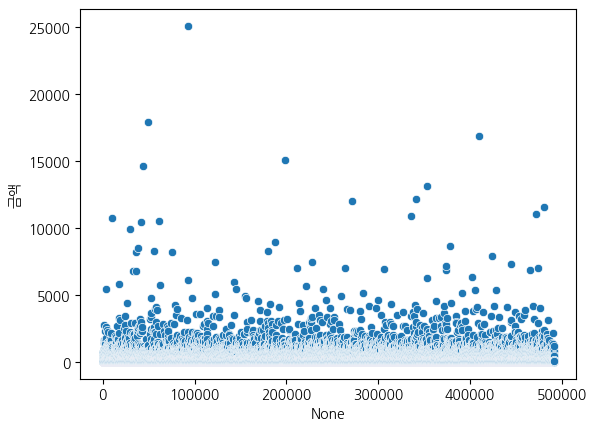

In [39]:
sns.scatterplot(fraud_df,x=fraud_df.index,y='금액')

In [40]:
fraud_df[fraud_df['금액'] > 10000][['금액','사기 여부']]
# 높은 거래 금액이 사기가 아니라는 증거가 될 수 있는 데이터이므로 제거하지 않고 남겨둔다.

,금액,사기 여부
9831,10776.59,0
42020,10469.09,0
43412,14630.68,0
49446,17897.24,0
61122,10525.07,0
93045,25086.94,0
198719,15047.03,0
271107,12025.30,0
336301,10881.08,0
341782,12176.55,0


### 인구 수

In [41]:
population=fraud_df.groupby(['주','도시'])['인구 수'].nunique().reset_index()
population[population['인구 수'] != 1]
# 각 주-도시 당 하나의 인구 수 값만 있으므로 오타로 인한 입력은 없다고 판단

,주,도시,인구 수


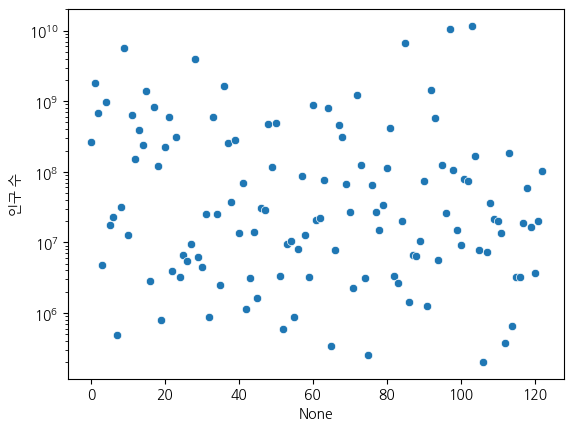

In [42]:
population=fraud_df.groupby(['주','도시'])['인구 수'].sum().reset_index()
sns.scatterplot(population, x=population.index, y='인구 수')
plt.yscale('log')

# 파생 변수

### ID 

In [156]:
fraud_df['ID']=(fraud_df['카드 번호']+fraud_df['이름']+fraud_df['성']+fraud_df['도로명']+fraud_df['우편번호']+fraud_df['생년월일'].astype('string')).apply(to_id)
fraud_df=fraud_df.drop(['카드 번호','이름','성','도로명','우편번호','생년월일'],axis=1)

In [157]:
fraud_df['ID']=fraud_df['ID'].astype('string')

## 이전 거래 시간

In [158]:
fraud_df['이전 거래 후(초)']=fraud_df.groupby('ID')['거래 발생 시간'].diff().dt.total_seconds()
fraud_df['이전 거래 후(초)']=fraud_df['이전 거래 후(초)'].fillna(-99)

In [159]:
fraud_df=fraud_df.drop('거래 발생 시간',axis=1)

# 원-핫 인코딩

In [160]:
fraud_df

,가맹점 이름,업종,금액,성별(남),도시,주,위도,경도,인구 수,직업,거래 번호,거래 위도,거래 경도,사기 여부,MII,나이,ID,이전 거래 후(초)
0,"Heller, Gutmann and Zieme",grocery_pos,107.23,0,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,6,47,f99e38e448ced175fda2da47195832f6c4bf83704be581...,-99.0
1,"Schultz, Simonis and Little",grocery_pos,44.71,1,Elizabeth,NJ,40.6747,-74.2239,124967,Operational researcher,09eff9c806365e2a6be12c1bbab3d70e,40.079588,-74.848087,0,4,44,8d11cf4af170a780b135e8eee53a4278c73029b7673f6f...,-99.0
2,Kling-Grant,grocery_net,46.28,0,Plainfield,NJ,40.6152,-74.4150,71485,Leisure centre manager,19e23c6a300c774354417befe4f31f8c,40.021888,-74.228188,0,1,51,72bde5611b2a71894564e406f29a6e31b5733e28cdc50b...,-99.0
3,Deckow-O'Conner,grocery_pos,64.09,1,Romulus,MI,42.2203,-83.3583,31515,Police officer,6f363661ba6b55889e488dd178f2a0af,42.360426,-83.552316,0,3,54,c308b0f132d91594305ce5b77fcbc05b3b780f2202d08c...,-99.0
4,Balistreri-Nader,misc_pos,25.58,0,Baton Rouge,LA,30.4066,-91.1468,378909,"Designer, furniture",1654da2abfb9e79a5f99167fc9779558,29.737426,-90.853194,0,2,48,e238ccbaf3b9bfbcba6f5429ca062b4ff5ca20ca58ef8f...,-99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491129,Botsford and Sons,home,134.26,0,Wilmington,NC,34.2651,-77.8670,186140,English as a second language teacher,fc860b0d1f89b0b068c9c8db27b6bcc5,34.853497,-78.664158,0,6,42,b8132316c5b1dc8970293aa9358bf55f548a8925cdf4b6...,1579.0
491130,"Baumbach, Hodkiewicz and Walsh",shopping_pos,25.49,0,Bradley,SC,34.0326,-82.2027,1523,Research scientist (physical sciences),0f0c38fe781b317f733b845c0d6ba448,35.008839,-81.475156,0,2,41,752140e6b4f20aaea1dd2c4acd7f4dce6e022dbd64e65b...,5257.0
491131,Hoppe-Parisian,kids_pets,111.84,1,Lake Jackson,TX,29.0393,-95.4401,28739,Futures trader,2090647dac2c89a1d86c514c427f5b91,29.661049,-96.186633,0,3,25,f186c9b9b0fe83a3cf0b55dff3d54c63100ad5ad4607e8...,9743.0
491132,Rau-Robel,kids_pets,86.88,0,Burbank,WA,46.1966,-118.9017,3684,Musician,6c5b7c8add471975aa0fec023b2e8408,46.658340,-119.715054,0,6,44,2e21c2e027ebb15a9684b1f8c684dad29bda333307d515...,724.0


# 데이터 분리

In [165]:
from sklearn.model_selection import train_test_split

smote=fraud_df[['금액','성별(남)','위도','경도','인구 수','거래 위도','거래 경도','나이','이전 거래 후(초)','사기 여부']]
X = smote.drop(columns=['사기 여부'],axis=1)
y = smote['사기 여부']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 오버샘플링

In [166]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [167]:
y.value_counts(), y_res.value_counts()

(사기 여부
 0    489890
 1      1244
 Name: count, dtype: int64,
 사기 여부
 0    489890
 1    489890
 Name: count, dtype: int64)

# 모델 적용

In [171]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=300,max_depth=3,random_state=42,n_jobs=-1)

In [172]:
model.fit(X_res,y_res)

,n_estimators,300
,criterion,'gini'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [176]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
con_mat=confusion_matrix(y_test, y_pred)
print(con_mat)
print(classification_report(y_test, y_pred, digits=4))

[[94379  3668]
 [   62   118]]
              precision    recall  f1-score   support

           0     0.9993    0.9626    0.9806     98047
           1     0.0312    0.6556    0.0595       180

    accuracy                         0.9620     98227
   macro avg     0.5153    0.8091    0.5201     98227
weighted avg     0.9976    0.9620    0.9789     98227



<Axes: >

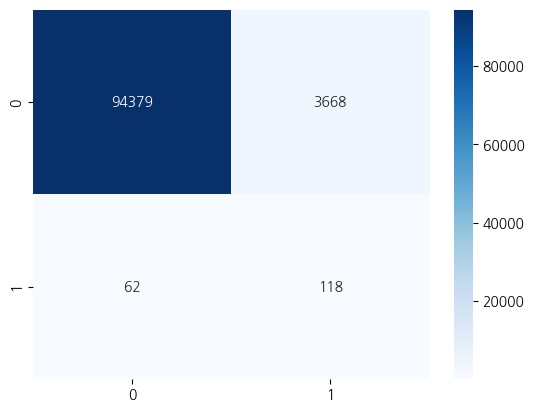

In [179]:
sns.heatmap(con_mat,annot=True,fmt='d',cmap='Blues')

온라인(net)에서 결제하는 게 훨씬 사기가 많을듯  
--- 조심해야할 건 온라인의 경우 거래 발생한 좌표가 다를 수도 있음  
많은 금액이더라도 사기가 많진 않네? 오히려 적은 금액으로 여러번이려나?  
주 - 도시를 묶는법  
 






